In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split    
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GroupKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import joblib
import os

## Testing with GradientBoost from XGBoost

In [2]:
df = pd.read_csv('dataset/train_data.csv')

In [3]:
df

,Driver,Qualifying_Time,Race_Time,LapNumber,Position,Compound,TyreLife,Weather_AirTemp,Weather_TrackTemp,Weather_Humidity,Weather_WindSpeed,Weather_Rainfall,Weather_Pressure,team,FP1_total_time,FP2_total_time,FP3_total_time,Year,EventName
0,ALB,90.474,110.771,1.0,15.0,MEDIUM,1.0,30.786250,36.445625,74.650000,0.955000,0.0,1008.024375,Williams,116.483687,114.911695,123.651452,2024,Pre-Season Testing
1,ALB,90.474,100.750,2.0,15.0,MEDIUM,2.0,30.786250,36.445625,74.650000,0.955000,0.0,1008.024375,Williams,116.483687,114.911695,123.651452,2024,Pre-Season Testing
2,ALB,90.474,99.762,3.0,15.0,MEDIUM,3.0,30.786250,36.445625,74.650000,0.955000,0.0,1008.024375,Williams,116.483687,114.911695,123.651452,2024,Pre-Season Testing
3,ALB,90.474,99.285,4.0,15.0,MEDIUM,4.0,30.786250,36.445625,74.650000,0.955000,0.0,1008.024375,Williams,116.483687,114.911695,123.651452,2024,Pre-Season Testing
4,ALB,90.474,99.252,5.0,15.0,MEDIUM,5.0,30.786250,36.445625,74.650000,0.955000,0.0,1008.024375,Williams,116.483687,114.911695,123.651452,2024,Pre-Season Testing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55739,ZHO,78.072,81.835,66.0,16.0,MEDIUM,24.0,19.888679,35.602516,51.050314,2.150943,0.0,785.252830,Kick Sauber,NaN,90.042270,111.329539,2024,Mexico City Grand Prix
55740,ZHO,78.072,82.056,67.0,16.0,MEDIUM,25.0,19.888679,35.602516,51.050314,2.150943,0.0,785.252830,Kick Sauber,NaN,90.042270,111.329539,2024,Mexico City Grand Prix
55741,ZHO,78.072,81.826,68.0,16.0,MEDIUM,26.0,19.888679,35.602516,51.050314,2.150943,0.0,785.252830,Kick Sauber,NaN,90.042270,111.329539,2024,Mexico City Grand Prix
55742,ZHO,78.072,83.604,69.0,15.0,MEDIUM,27.0,19.888679,35.602516,51.050314,2.150943,0.0,785.252830,Kick Sauber,NaN,90.042270,111.329539,2024,Mexico City Grand Prix


In [4]:
# Drop Race_Time column
X = df.drop(columns=['Race_Time'])
y = df['Race_Time']


In [5]:
df_test = pd.read_csv('dataset/test_data_2025.csv')

In [6]:
# Train/test split
features = X.columns.tolist()
# Remove unwanted features
for col_to_remove in ['FP1_total_time', 'FP2_total_time' ,'FP3_total_time', 'Weather_Humidity', 'Year', 'Position', 'team', 'Driver']:
    if col_to_remove in features:
        features.remove(col_to_remove)

categorical_features = X.select_dtypes(include=['object']).columns

# For categorical features, convert to 'category' dtype
for col in categorical_features:
    X[col] = X[col].astype('category')
    df_test[col] = df_test[col].astype('category')
    


X_train, X_val, y_train, y_val = train_test_split(X[features], y, test_size=0.2, random_state=42)
X_test = df_test[features]
y_test = df_test.loc[X_test.index, 'Race_Time']


In [7]:
# Build preprocessing pipeline: OneHotEncode categorical features, passthrough others
cat_cols = [c for c in categorical_features if c in features]
preprocessor = ColumnTransformer([('ohe', OneHotEncoder(handle_unknown='ignore'), cat_cols)], remainder='passthrough')

# Fit preprocessor on training data and transform train/val/test
X_train_proc = preprocessor.fit_transform(X_train[features])
X_val_proc = preprocessor.transform(X_val[features])
X_test_proc = preprocessor.transform(X_test[features])

In [8]:

param_dist = {
    'n_estimators': [2000, 2500, 3000],
    'learning_rate': [0.0005, 0.0025, 0.005],
    'max_depth': [1, 2, 3],
    'reg_alpha': [300, 400, 500],
    'reg_lambda': [80, 100, 150, 200],
    'min_child_weight': [1, 5, 10, 20],
    'subsample': [0.6, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.8, 1.0, 1.2],
}

xgb_search = XGBRegressor(
    enable_categorical=False,
    objective='reg:squarederror',
    random_state=42
)

gkf = GroupKFold(n_splits=5)

search = RandomizedSearchCV(
    xgb_search,
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_mean_absolute_error',
    cv=gkf,
    n_jobs=-1,
    verbose=2,
    random_state=42,
)

group_train = X.loc[X_train.index, 'Driver']
# Fit RandomizedSearch on the transformed data (param_dist unchanged)
search.fit(X_train_proc, y_train, groups=group_train, eval_set=[(X_val_proc, y_val)], verbose=False)

print("Best parameters found:", search.best_params_)
print("Best CV MAE:", -search.best_score_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


c:\Users\khanh\anaconda3\envs\DDSC\Lib\site-packages\sklearn\model_selection\_validation.py:490: FitFailedWarning: 
50 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\khanh\anaconda3\envs\DDSC\Lib\site-packages\sklearn\model_selection\_validation.py", line 833, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\khanh\anaconda3\envs\DDSC\Lib\site-packages\xgboost\core.py", line 774, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\khanh\anaconda3\envs\DDSC\Lib\site-packages\xgboost\sklearn.py", line 1368, in fit
    self._Booster = train(
          

Best parameters found: {'subsample': 0.8, 'reg_lambda': 80, 'reg_alpha': 400, 'n_estimators': 3000, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.0025, 'colsample_bytree': 1.0}
Best CV MAE: 4.596848775314402


[0]	validation_0-mae:11.30535	validation_1-mae:11.64014
[10]	validation_0-mae:11.14012	validation_1-mae:11.47235
[20]	validation_0-mae:10.98122	validation_1-mae:11.31053
[30]	validation_0-mae:10.82894	validation_1-mae:11.15515
[40]	validation_0-mae:10.68122	validation_1-mae:11.00427
[50]	validation_0-mae:10.53900	validation_1-mae:10.85900
[60]	validation_0-mae:10.40146	validation_1-mae:10.71828
[70]	validation_0-mae:10.26826	validation_1-mae:10.58200
[80]	validation_0-mae:10.13853	validation_1-mae:10.44917
[90]	validation_0-mae:10.00910	validation_1-mae:10.31676
[100]	validation_0-mae:9.88312	validation_1-mae:10.18769
[110]	validation_0-mae:9.76201	validation_1-mae:10.06374
[120]	validation_0-mae:9.64293	validation_1-mae:9.94186
[130]	validation_0-mae:9.52793	validation_1-mae:9.82405
[140]	validation_0-mae:9.41747	validation_1-mae:9.71097
[150]	validation_0-mae:9.30845	validation_1-mae:9.59916
[160]	validation_0-mae:9.20334	validation_1-mae:9.49139
[170]	validation_0-mae:9.10145	valida

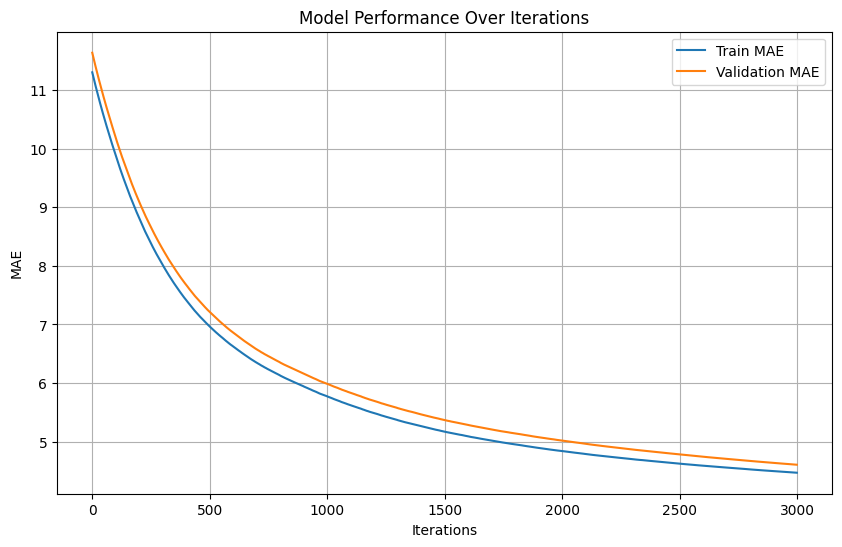

In [9]:
best_params = search.best_params_

# Retrain with eval_set to get evals_result using transformed data
final_model = XGBRegressor(
    **best_params,
    enable_categorical=False,
    objective='reg:squarederror',
    random_state=42,
    eval_metric='mae',
    early_stopping_rounds=20,  # stop if no improvement after 20 rounds

)

final_model.fit(
    X_train_proc, y_train,
    eval_set=[(X_train_proc, y_train), (X_val_proc, y_val)],
    verbose=10

)

results = final_model.evals_result()
# Plot training and validation error
plt.figure(figsize=(10, 6))
plt.plot(results['validation_0']['mae'], label='Train MAE')
plt.plot(results['validation_1']['mae'], label='Validation MAE')
plt.xlabel('Iterations')
plt.ylabel('MAE')
plt.title('Model Performance Over Iterations')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
unseen = []

# check for unseen categories in X_test
for col in categorical_features:
    if col in X_test.columns:
        unseen_categories = set(X_test[col].unique()) - set(X[col].cat.categories)
        if unseen_categories:
            unseen.append((col, unseen_categories))
            print(f"Unseen categories in column '{col}': {unseen_categories}")
            



Unseen categories in column 'Compound': {nan}
Unseen categories in column 'EventName': {'Las Vegas Grand Prix', 'São Paulo Grand Prix', 'Abu Dhabi Grand Prix', 'Qatar Grand Prix'}


In [11]:
# Evaluate on test set
y_pred = final_model.predict(X_test_proc)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Test MSE: {mse}")
print(f"Test MAE: {mae}")
print(f"Test R2: {r2}")




Test MSE: 87.51838142176716
Test MAE: 4.843082571966139
Test R2: 0.522842980292213


In [12]:
joblib.dump(preprocessor, 'model_data/preprocessor.joblib')
joblib.dump(final_model, 'model_data/xgb_model.joblib')
joblib.dump(features, 'model_data/features.joblib')
joblib.dump(cat_cols, 'model_data/cat_cols.joblib')

['model_data/cat_cols.joblib']